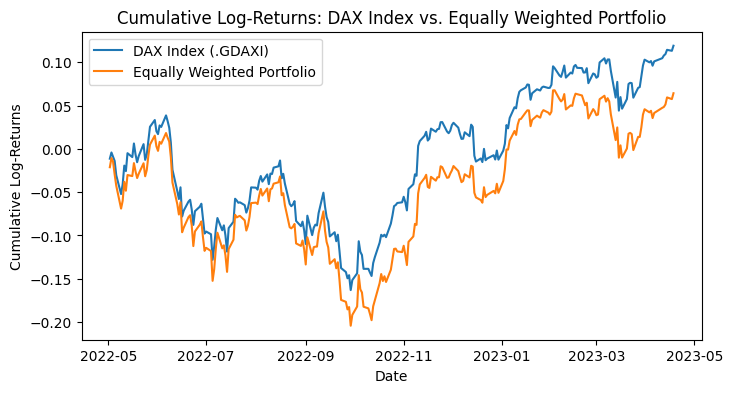

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from a CSV file
data = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
daily_returns = data.pct_change()
log_daily_returns = np.log(data) - np.log(data.shift(1))

# DAX Index calculation
cumulative_log_returns_dax = log_daily_returns['.GDAXI'].cumsum()

# Portfolio calculation
log_returns_without_dax = log_daily_returns.drop(columns=['.GDAXI'])
# Equal weight allocation
portfolio_weights = np.ones(len(log_returns_without_dax.columns)) / len(log_returns_without_dax.columns)
log_returns_portfolio = log_returns_without_dax.dot(portfolio_weights)
cumulative_log_returns_portfolio = log_returns_portfolio.cumsum()

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(cumulative_log_returns_dax, label='DAX Index (.GDAXI)')
plt.plot(cumulative_log_returns_portfolio, label='Equally Weighted Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')
plt.legend()
plt.title('Cumulative Log-Returns: DAX Index vs. Equally Weighted Portfolio')
plt.show()

In [2]:
from scipy.stats import norm
import numpy as np
import pandas as pd

# Historical simulation for VaR
historical_var_dax = -log_daily_returns['.GDAXI'].quantile(0.05)
historical_var_portfolio = -log_returns_portfolio.quantile(0.05)

# Parametric VaR (assuming normal distribution)
dax_std_dev = log_daily_returns['.GDAXI'].std()
# Assuming a short time horizon (e.g., 1 day) where mu = 0 is reasonable
parametric_var_dax = -norm.ppf(0.95) * dax_std_dev
portfolio_std_dev = log_returns_portfolio.std()
parametric_var_portfolio = -norm.ppf(0.95) * portfolio_std_dev

# Monte Carlo simulation for VaR
num_simulations = 10000
time_horizon_days = 1

simulated_dax_returns = np.random.normal(0, dax_std_dev * np.sqrt(time_horizon_days), num_simulations)
simulated_portfolio_returns = np.random.normal(0, portfolio_std_dev * np.sqrt(time_horizon_days), num_simulations)
monte_carlo_var_dax = -np.percentile(simulated_dax_returns, 5)
monte_carlo_var_portfolio = -np.percentile(simulated_portfolio_returns, 5)

# Displaying the VaR results in a table
var_results = pd.DataFrame({
    'DAX Index (.GDAXI)': [historical_var_dax, parametric_var_dax, monte_carlo_var_dax],
    'Equally Weighted Portfolio': [historical_var_portfolio, parametric_var_portfolio, monte_carlo_var_portfolio]
}, index=['Historical Simulation', 'Parametric Method', 'Monte Carlo Simulation'])

print(var_results)


                        DAX Index (.GDAXI)  Equally Weighted Portfolio
Historical Simulation             0.019456                    0.021996
Parametric Method                -0.019895                   -0.021166
Monte Carlo Simulation            0.019811                    0.021292


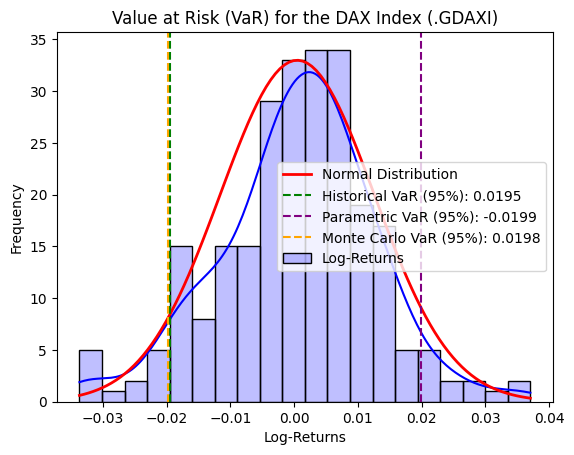

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# Plotting histogram of log-returns
sns.histplot(log_daily_returns['.GDAXI'].dropna(), kde=True, bins=20, color='blue', alpha=0.25, label='Log-Returns')

# Adding normal distribution PDF line
x_vals = np.linspace(log_daily_returns['.GDAXI'].min(), log_daily_returns['.GDAXI'].max(), 100)
normal_pdf = norm.pdf(x_vals, log_daily_returns['.GDAXI'].mean(), log_daily_returns['.GDAXI'].std())
plt.plot(x_vals, normal_pdf, 'r', linewidth=2, label='Normal Distribution')

# Adding VaR indicators
plt.axvline(x=-historical_var_dax, color='g', linestyle='--', label=f'Historical VaR (95%): {historical_var_dax:.4f}')
plt.axvline(x=-parametric_var_dax, color='purple', linestyle='--', label=f'Parametric VaR (95%): {parametric_var_dax:.4f}')
plt.axvline(x=-monte_carlo_var_dax, color='orange', linestyle='--', label=f'Monte Carlo VaR (95%): {monte_carlo_var_dax:.4f}')

# Customizing plot
plt.legend()
plt.title("Value at Risk (VaR) for the DAX Index (.GDAXI)")
plt.xlabel("Log-Returns")
plt.ylabel("Frequency")
plt.show()
